## Continuous Futures

Continuous Futures are an abstraction of the chain of consecutive contracts for the same underlying commodity or asset. Additionally, they maintain an ongoing reference to the active contract on the chain. Continuous futures make it much easier to maintain a dynamic reference to contracts that you want to order, and get historical series of data. In this lesson, we will explore some of the ways in which we can use continuous futures to help us in our research.

In order to create an instance of a `ContinuousFuture` in Research, we need to use the <a href="https://www.quantopian.com/help#quantopian_research_experimental_continuous_future">continuous_future</a> function. Similar to history, we need to import it from research's experimental library:

In [5]:
from quantopian.research.experimental import continuous_future, history

To create a continuous future, we just need to supply a root_symbol to the `continuous_future` function. The following cell creates a continuous future for Light Sweet Crude Oil.

In [6]:
cl = continuous_future('CL')
cl

ContinuousFuture(90999980378095616, root_symbol='CL', offset=0, roll_style='volume', adjustment='mul')

### Continuous Futures & `history`

We can use `history` to get pricing and volume data for a particular `ContinuousFuture` in the same way we do for `Futures`. Additionally, we can get the reference to its currently active `Future` contract by using the `contract` field.

Running the next cell will get pricing data for our CL continuous future and plot it:

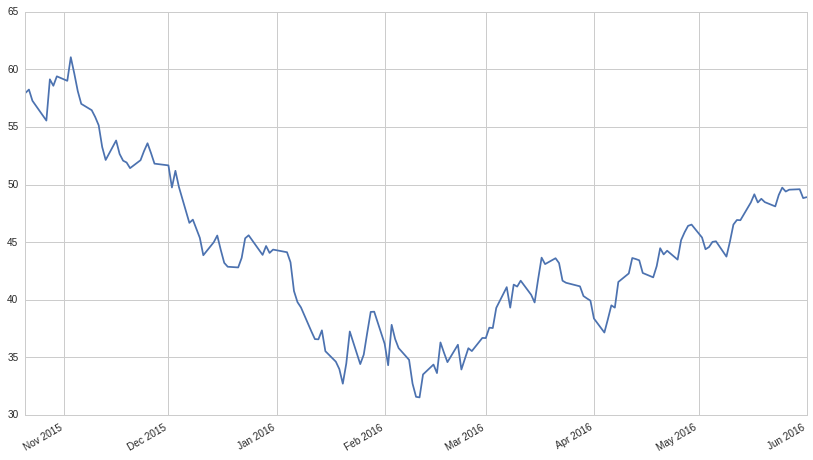

In [7]:
# Pricing data for CL `ContinuousFuture`.
cl_pricing = history(
    cl, 
    fields='price', 
    frequency='daily', 
    start='2015-10-21', 
    end='2016-06-01'
)

cl_pricing.plot()

To better understand the need for continuous futures, let's use `history` to get pricing data for the chain of individual contracts we looked at in the previous lesson and plot it.

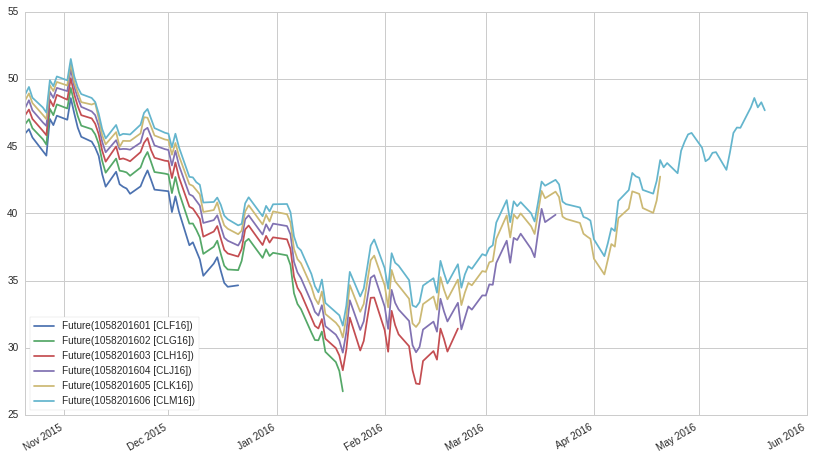

In [8]:
cl_contracts = symbols(['CLF16', 'CLG16', 'CLH16', 'CLJ16', 'CLK16', 'CLM16'])

# Pricing data for our consecutive contracts from earlier.
cl_consecutive_contract_pricing = history(
    cl_contracts, 
    fields='price', 
    frequency='daily', 
    start='2015-10-21', 
    end='2016-06-01'
)

cl_consecutive_contract_pricing.plot();

The price difference between contracts at a given time is not considered to be an increase in value in the future. Instead, it is associated with the carrying cost and the opportunity cost of holding the underlying commodity or asset prior to delivery. This concept is covered more in depth in the Introduction to Futures Contracts lecture from our <a href="https://www.quantopian.com/lectures">Lecture Series</a>.

Next, let's look at the price history for active contracts separately. We will notice that this difference in price creates discontinuities when a contract expires and the reference moves to the next contract:

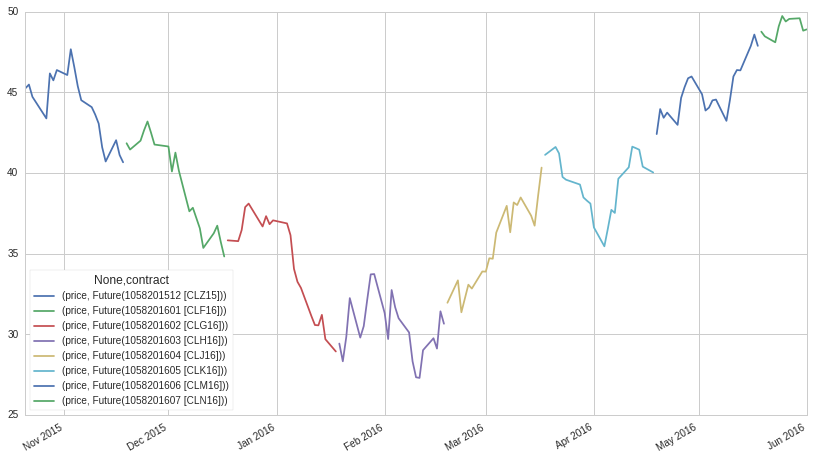

In [9]:
# Pricing and contract data for unadjusted CL `ContinuousFuture`.
# Adjustments are covered in the next section. 
cl_unadjusted = continuous_future('CL', adjustment=None)

cl_history = history(
    cl_unadjusted, 
    fields=['contract', 'price'], 
    frequency='daily', 
    start='2015-10-21', 
    end='2016-06-01'
)

cl_active_contract_pricing = cl_history.pivot(index=cl_history.index, columns='contract')
cl_active_contract_pricing.plot();

Part of the job of our continuous future abstraction is to account for these discontinuities, as we will see next by plotting our CL continuous future price against the price history for individual active contracts.

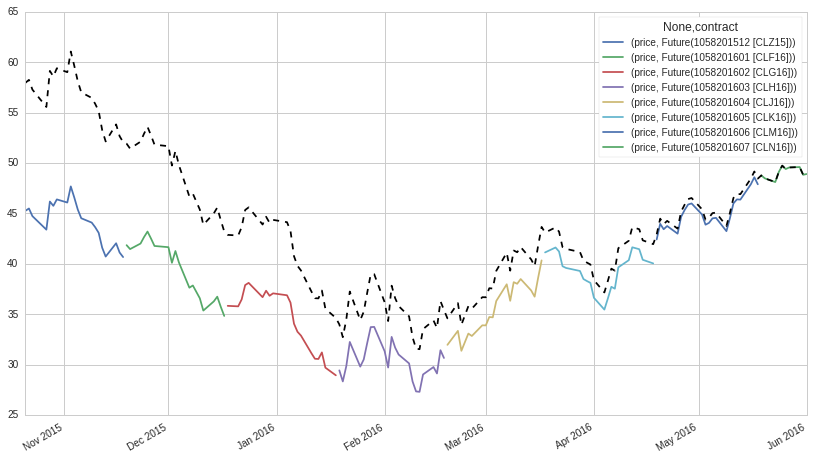

In [10]:
cl_active_contract_pricing.plot()
cl_pricing.plot(style='k--')

The above plot is adjusted for the price jumps that we see between contracts. This allows us to get a price series that reflects the changes in the price of the actual underlying commodity/asset.

In the next section, we will explore the options for adjusting historical lookback windows of continuous futures.

### Adjustment Styles

As we just saw, continuous future historical data series are adjusted to account for price jumps between contracts by default. This can be overridden by specifying an adjustment argument when creating the continuous future. The adjustment argument has 3 options: `'mul'` (default), `'add'`, and `None`.

The `'mul'` option multiplies the prices series by the ratio of consecutive contract prices. The effect from each jump is only applied to prices further back in the lookback window.

Similarly, the `'add'` technique adjusts by the difference between consecutive contract prices.

Finally, passing `None` means that no adjustments will be applied to the lookback window.

### Roll Styles

In the previous lesson we saw that trading activity jumps from one contract in the chain to the next as they approach their delivery date. A continuous future changes its reference from the active contract to the next bassed on its roll attribute.

A `'calendar'` roll means that the continuous future will point to the next contract in the chain when it reaches the `auto_close_date` of the current active contract.

The `volume` roll (default) means that the continuous future will begin pointing to the next contract when the trading volume of the next contract surpasses the volume of the current contract. The idea is to roll when the majority of traders have moved to the next contract. If the volume swap doesn't happen before the `auto_close_date`, the contract will roll at this date. Note: volume rolls will not occur earlier than 7 trading days before the `auto_close_date`.

Let's get the volume history of our CL continuous future and plot it against the individual contract volumes we saw before.

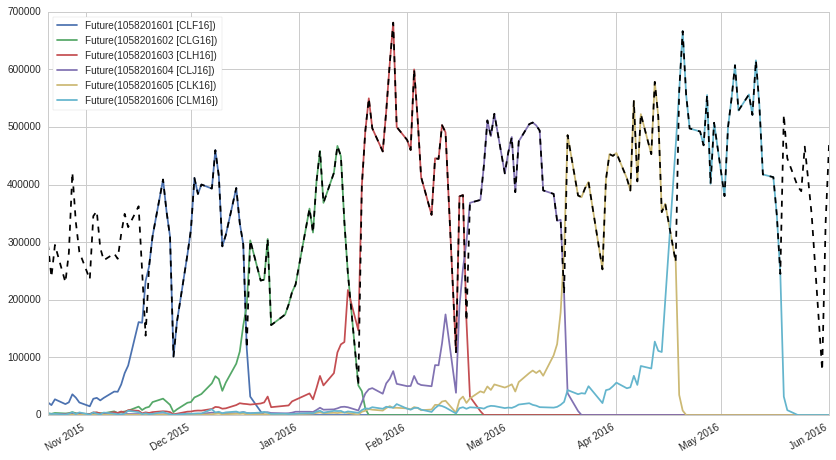

In [11]:
cl_consecutive_contract_data = history(
    cl_contracts, 
    fields='volume', 
    frequency='daily', 
    start='2015-10-21', 
    end='2016-06-01'
)

cl_continuous_volume = history(
    cl, 
    fields='volume', 
    frequency='daily', 
    start='2015-10-21', 
    end='2016-06-01'
)

cl_consecutive_contract_data.plot()

cl_continuous_volume.plot(style='k--');

The volume for the CL `ContinuousFuture` is essentially the skyline of the individual contract volumes. As the volume moves from one contract to the next, the continuous future starts pointing to the next contract. Note that there are some points where the volume does not exactly match, most notably in the transition from `CLK16` to `CLM16` between April and May. This is because the rolls are currently computed daily, using only the previous day's volume to avoid lookahead bias.

### Offset

The offset argument allows you to specify whether you want to maintain a reference to the front contract or to a back contract. Setting offset=0 (default) maintains a reference to the front contract, or the contract with the next soonest delivery. Setting offset=1 creates a continuous reference to the contract with the second closest date of delivery, etc.

In [12]:
print continuous_future.__doc__


    Create a specifier for a continuous contract.

    Parameters
    ----------
    root_symbol : str
        The root symbol for the continuous future.

    offset : int, optional
        The distance from the primary contract. Default is 0.

    roll : str, optional
        How rolls are determined. Options are 'volume' and 'calendar'. Default
        is 'volume'.

    adjustment : str
        Method for adjusting lookback prices between rolls. Options are
        'mul', 'add', and None. Default is 'mul'.

    Returns
    -------
    continuous_future : ContinuousFuture
        The continuous future specifier.
    
